# Climate Headlines Collection from RSS Feeds

This notebook collects climate-related news headlines from major news outlets using RSS feeds. This will complement our climate tweets dataset for cross-media emotion analysis.

## Objectives:
1. Collect headlines from multiple news sources
2. Filter for climate-related content
3. Clean and preprocess the data
4. Save processed headlines for emotion analysis
5. Compare with climate tweets characteristics

## 1. Import Required Libraries

In [36]:
# Core data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import re
import json
import os
from collections import defaultdict

# RSS and web scraping
import feedparser
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Progress tracking
from tqdm.notebook import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Current time: {datetime.now()}")

Libraries imported successfully!
Current time: 2025-08-20 17:58:12.843007


## 2. Download NLTK Data (if needed)

In [37]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ NLTK punkt tokenizer already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt tokenizer...")
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
    print("✅ NLTK stopwords already downloaded")
except LookupError:
    print("📥 Downloading NLTK stopwords...")
    nltk.download('stopwords')

print("✅ NLTK data ready!")

✅ NLTK punkt tokenizer already downloaded
✅ NLTK stopwords already downloaded
✅ NLTK data ready!


## 3. Define RSS Feed Sources and Climate Keywords

In [38]:
# Major news outlets RSS feeds
RSS_FEEDS = {
    # Major News Outlets - Environment/Science
    'BBC_Science': 'http://feeds.bbci.co.uk/news/science_and_environment/rss.xml',
    'CNN_World': 'http://rss.cnn.com/rss/edition.rss',
    'Reuters_Environment': 'https://www.reuters.com/arc/outboundfeeds/rss/category/environment/?size=25',
    'Guardian_Environment': 'https://www.theguardian.com/environment/rss',
    'NPR_Climate': 'https://feeds.npr.org/1025/rss.xml',
    'AP_Science': 'https://apnews.com/rss/ScienceNews',
    'Washington_Post_Climate': 'https://feeds.washingtonpost.com/rss/business/technology/climate-solutions',
    'NYTimes_Climate': 'https://rss.nytimes.com/services/xml/rss/nyt/Climate.xml',
    'Scientific_American': 'https://rss.sciam.com/ScientificAmerican-Global',
    
    # Specialized Climate and Environmental Media
    'Nature_Climate': 'https://www.nature.com/nclimate.rss',
    'Climate_Central': 'https://www.climatecentral.org/feed',
    'Inside_Climate_News': 'https://insideclimatenews.org/feed/',
    'Carbon_Brief': 'https://www.carbonbrief.org/feed/',
    'Yale_Environment_360': 'https://e360.yale.edu/feed',
    'Environment_News_Service': 'https://ens-newswire.com/feed/',
    'Grist_Climate': 'https://grist.org/feed/',
    'Climate_Home_News': 'https://www.climatechangenews.com/feed/',
    'DeSmog_Climate': 'https://www.desmog.com/feed/',
    'EcoWatch': 'https://www.ecowatch.com/feeds/all.rss',
    'Environmental_Health_News': 'https://www.ehn.org/rss.xml',
    
    # Energy and Clean Tech
    'Greentech_Media': 'https://www.greentechmedia.com/rss/all',
    'Renewable_Energy_World': 'https://www.renewableenergyworld.com/feeds/all/',
    'CleanTechnica': 'https://cleantechnica.com/feed/',
    'Energy_Central': 'https://energycentral.com/rss.xml',
    'PV_Magazine': 'https://www.pv-magazine.com/feed/',
    'Wind_Power_Engineering': 'https://www.windpowerengineering.com/feed/',
    'Electric_Light_Power': 'https://www.elp.com/rss',
    
    # Policy and Politics
    'ClimateWire': 'https://www.eenews.net/rss/climatewire',
    'Politico_Energy': 'https://www.politico.com/rss/energy.xml',
    'The_Hill_Energy': 'https://thehill.com/policy/energy-environment/feed/',
    'E&E_News': 'https://www.eenews.net/rss/all',
    'Climate_Policy_Initiative': 'https://www.climatepolicyinitiative.org/feed/',
    
    # Business and Finance
    'Forbes_Sustainability': 'https://www.forbes.com/sustainability/feed/',
    'Bloomberg_Green': 'https://feeds.bloomberg.com/climate',
    'GreenBiz': 'https://www.greenbiz.com/feed',
    'Sustainable_Brands': 'https://sustainablebrands.com/rss.xml',
    'Triple_Pundit': 'https://www.3bl.media/rss',
    
    # International Sources
    'Guardian_UK_Environment': 'https://www.theguardian.com/uk/environment/rss',
    'Guardian_Climate_Crisis': 'https://www.theguardian.com/environment/climate-crisis/rss',
    'Independent_Environment': 'https://www.independent.co.uk/environment/rss',
    'Telegraph_Earth': 'https://www.telegraph.co.uk/earth/rss',
    'Deutsche_Welle_Environment': 'https://rss.dw.com/rdf/rss-en-environment',
    'France24_Environment': 'https://www.france24.com/en/environment/rss',
    'Euronews_Green': 'https://www.euronews.com/rss?format=mrss&level=theme&name=green',
    
    # Science and Research
    'Science_Daily_Environment': 'https://www.sciencedaily.com/rss/earth_climate/climate.xml',
    'Science_Daily_Earth_Climate': 'https://www.sciencedaily.com/rss/earth_climate.xml',
    'Phys_Org_Environment': 'https://phys.org/rss-feed/earth-news/',
    'Phys_Org_Environment_Specific': 'https://phys.org/rss-feed/earth-news/environment/',
    'Earth_Institute_Columbia': 'https://www.earth.columbia.edu/sitefiles/file/RSS_All_News_feed.xml',
    'NASA_Climate': 'https://climate.nasa.gov/rss/news.xml',
    'NOAA_Climate': 'https://www.climate.gov/rss.xml',
    'Nature_Climate_Change_Subjects': 'https://www.nature.com/subjects/climate-change.rss',
    'Yale_Climate_Connections': 'https://yaleclimateconnections.org/feed/',
    'The_Conversation_Climate': 'https://theconversation.com/global/topics/climate-change-30/articles.atom',
    
    # Environmental Organizations
    'Greenpeace': 'https://www.greenpeace.org/international/feed/',
    'Sierra_Club': 'https://www.sierraclub.org/rss/all.xml',
    'WWF_News': 'https://www.worldwildlife.org/rss',
    'Natural_Resources_Defense_Council': 'https://www.nrdc.org/rss.xml',
    'Environmental_Defense_Fund': 'https://www.edf.org/rss.xml',
    'Friends_of_Earth': 'https://foe.org/feed/',
    '350_Org': 'https://350.org/feed/',
    
    # Regional US Sources
    'USA_Today_Environment': 'https://www.usatoday.com/rss/news/environment/',
    'LA_Times_Environment': 'https://www.latimes.com/environment/rss2.0.xml',
    'SF_Chronicle_Environment': 'https://www.sfchronicle.com/environment/rss/',
    'Chicago_Tribune_Environment': 'https://www.chicagotribune.com/arcio/rss/category/news/environment/',
    
    # Tech and Innovation
    'MIT_Technology_Review_Climate': 'https://www.technologyreview.com/topic/climate-change/feed/',
    'Wired_Science': 'https://www.wired.com/feed/category/science',
    'Ars_Technica_Science': 'https://feeds.arstechnica.com/arstechnica/science',
    
    # Alternative Energy and Sustainability
    'Solar_Power_World': 'https://www.solarpowerworldonline.com/feed/',
    'Biomass_Magazine': 'https://biomassmagazine.com/rss.xml',
    'Hydropower_News': 'https://www.hydropower.org/rss.xml',
    'Geothermal_Energy': 'https://www.geothermal-energy.org/rss.xml',
    
    # Agricultural and Food
    'Food_and_Environment_Reporting': 'https://thefern.org/feed/',
    'Civil_Eats': 'https://civileats.com/feed/',
    'Modern_Farmer': 'https://modernfarmer.com/feed/',
    
    # Local Environmental News
    'Earth_Justice': 'https://earthjustice.org/rss',
    'Environmental_Working_Group': 'https://www.ewg.org/rss',
    'Union_of_Concerned_Scientists': 'https://www.ucsusa.org/rss.xml',
    
    # News Aggregators
    'Google_News_Climate_Change': 'https://news.google.com/rss/search?q=climate+change',
    'Google_News_Global_Warming': 'https://news.google.com/rss/search?q=global+warming',
}

# Climate-related keywords for filtering
CLIMATE_KEYWORDS = [
    # Core climate terms
    'climate change', 'global warming', 'greenhouse gas', 'carbon emission',
    'carbon dioxide', 'co2', 'methane', 'fossil fuel', 'renewable energy',
    
    # Weather and natural disasters
    'extreme weather', 'heat wave', 'drought', 'wildfire', 'flooding',
    'hurricane', 'typhoon', 'cyclone', 'storm surge', 'sea level rise',
    
    # Environmental impact
    'deforestation', 'ocean acidification', 'coral bleaching', 'biodiversity loss',
    'extinction', 'ecosystem', 'habitat loss', 'pollution', 'air quality',
    
    # Climate action and policy
    'paris agreement', 'cop27', 'cop28', 'cop29', 'net zero', 'carbon neutral',
    'sustainability', 'green energy', 'solar power', 'wind power',
    'electric vehicle', 'climate policy', 'environmental protection',
    
    # Additional climate terms
    'carbon footprint', 'emissions reduction', 'clean energy', 'climate crisis',
    'climate emergency', 'global temperature', 'ice melting', 'permafrost',
    'climate adaptation', 'climate mitigation', 'carbon sequestration',
    'green transition', 'energy transition', 'climate finance', 'climate justice',
    'environmental justice', 'climate activism', 'climate denial', 'ipcc',
    'carbon tax', 'cap and trade', 'carbon pricing', 'green new deal'
]

print(f"📰 News sources configured: {len(RSS_FEEDS)}")
print(f"🔍 Climate keywords: {len(CLIMATE_KEYWORDS)}")
print("\nNews Sources by Category:")

# Organize sources by category for better display
categories = {
    'Major News': ['BBC_Science', 'CNN_World', 'Reuters_Environment', 'Guardian_Environment', 'NPR_Climate'],
    'Climate Specialists': ['Climate_Central', 'Inside_Climate_News', 'Carbon_Brief', 'Grist_Climate', 'Yale_Climate_Connections'],
    'Energy & Tech': ['Greentech_Media', 'CleanTechnica', 'Bloomberg_Green'],
    'Environmental Orgs': ['Greenpeace', 'Sierra_Club', 'WWF_News', '350_Org'],
    'Science & Research': ['Nature_Climate', 'NASA_Climate', 'Science_Daily_Environment', 'The_Conversation_Climate'],
    'News Aggregators': ['Google_News_Climate_Change', 'Google_News_Global_Warming']
}

for category, sources in categories.items():
    print(f"\n{category}:")
    for source in sources:
        if source in RSS_FEEDS:
            print(f"  • {source}")

print(f"\n... and {len(RSS_FEEDS) - sum(len(sources) for sources in categories.values())} more sources!")
print(f"\nTotal RSS feeds: {len(RSS_FEEDS)}")
print(f"Climate keywords: {len(CLIMATE_KEYWORDS)}")

📰 News sources configured: 80
🔍 Climate keywords: 64

News Sources by Category:

Major News:
  • BBC_Science
  • CNN_World
  • Reuters_Environment
  • Guardian_Environment
  • NPR_Climate

Climate Specialists:
  • Climate_Central
  • Inside_Climate_News
  • Carbon_Brief
  • Grist_Climate
  • Yale_Climate_Connections

Energy & Tech:
  • Greentech_Media
  • CleanTechnica
  • Bloomberg_Green

Environmental Orgs:
  • Greenpeace
  • Sierra_Club
  • WWF_News
  • 350_Org

Science & Research:
  • Nature_Climate
  • NASA_Climate
  • Science_Daily_Environment
  • The_Conversation_Climate

News Aggregators:
  • Google_News_Climate_Change
  • Google_News_Global_Warming

... and 57 more sources!

Total RSS feeds: 80
Climate keywords: 64


## 4. RSS Feed Collection Functions

In [39]:
class ClimateHeadlineCollector:
    """Collector for climate-related news headlines from RSS feeds"""
    
    def __init__(self, keywords=None, max_retries=3, delay=1.0):
        self.keywords = keywords or CLIMATE_KEYWORDS
        self.max_retries = max_retries
        self.delay = delay
        self.collected_headlines = []
        self.failed_feeds = []
        
    def is_climate_related(self, text):
        """Check if text contains climate-related keywords"""
        if not text:
            return False
        
        text_lower = text.lower()
        return any(keyword.lower() in text_lower for keyword in self.keywords)
    
    def clean_text(self, text):
        """Clean and normalize text content"""
        if not text:
            return ""
        
        # Remove HTML tags
        text = BeautifulSoup(text, 'html.parser').get_text()
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s\-.,!?;:\'"()]', '', text)
        
        return text
    
    def fetch_rss_feed(self, url, source_name):
        """Fetch and parse RSS feed with retry logic"""
        for attempt in range(self.max_retries):
            try:
                print(f"  📡 Fetching {source_name} (attempt {attempt + 1})...")
                
                # Add headers to avoid blocking
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                }
                
                # Fetch with timeout
                response = requests.get(url, headers=headers, timeout=15)
                response.raise_for_status()
                
                # Parse RSS feed
                feed = feedparser.parse(response.content)
                
                if feed.bozo and feed.bozo_exception:
                    print(f"    ⚠️  Warning: {feed.bozo_exception}")
                
                return feed
                
            except Exception as e:
                print(f"    ❌ Attempt {attempt + 1} failed: {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.delay * (attempt + 1))  # Progressive delay
        
        self.failed_feeds.append((source_name, url))
        return None
    
    def extract_headlines_from_feed(self, feed, source_name):
        """Extract headlines from parsed RSS feed"""
        headlines = []
        
        if not feed or not hasattr(feed, 'entries'):
            return headlines
        
        print(f"    📄 Found {len(feed.entries)} entries")
        
        for entry in feed.entries:
            try:
                # Extract basic information
                title = self.clean_text(getattr(entry, 'title', ''))
                summary = self.clean_text(getattr(entry, 'summary', ''))
                link = getattr(entry, 'link', '')
                
                # Extract publication date
                pub_date = None
                if hasattr(entry, 'published_parsed') and entry.published_parsed:
                    pub_date = datetime(*entry.published_parsed[:6])
                elif hasattr(entry, 'updated_parsed') and entry.updated_parsed:
                    pub_date = datetime(*entry.updated_parsed[:6])
                
                # Check if climate-related
                full_text = f"{title} {summary}"
                if self.is_climate_related(full_text):
                    headline_data = {
                        'title': title,
                        'summary': summary,
                        'source': source_name,
                        'url': link,
                        'published_date': pub_date,
                        'collected_date': datetime.now(),
                        'text_length': len(title),
                        'summary_length': len(summary)
                    }
                    headlines.append(headline_data)
                    
            except Exception as e:
                print(f"    ⚠️  Error processing entry: {e}")
                continue
        
        climate_count = len(headlines)
        total_count = len(feed.entries)
        
        if total_count > 0:
            percentage = climate_count/total_count*100
            print(f"    🌍 Climate-related: {climate_count}/{total_count} ({percentage:.1f}%)")
        else:
            print(f"    🌍 Climate-related: {climate_count}/0 (No entries found)")
        
        return headlines
    
    def collect_all_headlines(self, rss_feeds):
        """Collect headlines from all RSS feeds"""
        print(f"🚀 Starting headline collection from {len(rss_feeds)} sources...")
        print("=" * 60)
        
        all_headlines = []
        source_stats = {}
        
        for source_name, url in tqdm(rss_feeds.items(), desc="Processing feeds"):
            print(f"\n📰 Processing {source_name}")
            
            # Fetch RSS feed
            feed = self.fetch_rss_feed(url, source_name)
            
            if feed:
                # Extract headlines
                headlines = self.extract_headlines_from_feed(feed, source_name)
                all_headlines.extend(headlines)
                source_stats[source_name] = len(headlines)
                print(f"    ✅ Collected {len(headlines)} climate headlines")
            else:
                source_stats[source_name] = 0
                print(f"    ❌ Failed to fetch feed")
            
            # Be respectful to servers
            time.sleep(self.delay)
        
        self.collected_headlines = all_headlines
        
        print("\n" + "=" * 60)
        print("📊 COLLECTION SUMMARY")
        print("=" * 60)
        print(f"Total headlines collected: {len(all_headlines)}")
        print(f"Successful sources: {len([s for s in source_stats.values() if s > 0])}/{len(rss_feeds)}")
        print(f"Failed sources: {len(self.failed_feeds)}")
        
        if source_stats:
            print("\nHeadlines per source:")
            for source, count in sorted(source_stats.items(), key=lambda x: x[1], reverse=True):
                status = "✅" if count > 0 else "❌"
                print(f"  {status} {source:20s}: {count:3d} headlines")
        
        if self.failed_feeds:
            print("\n❌ Failed feeds:")
            for source, url in self.failed_feeds:
                print(f"  • {source}: {url}")
        
        return all_headlines

print("✅ ClimateHeadlineCollector class defined!")

✅ ClimateHeadlineCollector class defined!


## 5. Collect Headlines from RSS Feeds

In [40]:
# Initialize collector
collector = ClimateHeadlineCollector(
    keywords=CLIMATE_KEYWORDS,
    max_retries=3,
    delay=2.0  # 2 second delay between requests
)

# Collect headlines
headlines = collector.collect_all_headlines(RSS_FEEDS)

🚀 Starting headline collection from 80 sources...


Processing feeds:   0%|          | 0/80 [00:00<?, ?it/s]


📰 Processing BBC_Science
  📡 Fetching BBC_Science (attempt 1)...
    📄 Found 59 entries
    🌍 Climate-related: 11/59 (18.6%)
    ✅ Collected 11 climate headlines
    📄 Found 59 entries
    🌍 Climate-related: 11/59 (18.6%)
    ✅ Collected 11 climate headlines

📰 Processing CNN_World
  📡 Fetching CNN_World (attempt 1)...

📰 Processing CNN_World
  📡 Fetching CNN_World (attempt 1)...
    📄 Found 50 entries
    🌍 Climate-related: 1/50 (2.0%)
    ✅ Collected 1 climate headlines
    📄 Found 50 entries
    🌍 Climate-related: 1/50 (2.0%)
    ✅ Collected 1 climate headlines

📰 Processing Reuters_Environment
  📡 Fetching Reuters_Environment (attempt 1)...

📰 Processing Reuters_Environment
  📡 Fetching Reuters_Environment (attempt 1)...
    ❌ Attempt 1 failed: 404 Client Error: Not Found for url: https://www.reuters.com/arc/outboundfeeds/rss/category/environment/?size=25
    ❌ Attempt 1 failed: 404 Client Error: Not Found for url: https://www.reuters.com/arc/outboundfeeds/rss/category/environment

## 6. Convert to DataFrame and Analyze

In [41]:
# Convert to DataFrame
if headlines:
    df_headlines = pd.DataFrame(headlines)
    
    print(f"📊 Created DataFrame with {len(df_headlines)} headlines")
    print(f"📅 Date range: {df_headlines['published_date'].min()} to {df_headlines['published_date'].max()}")
    print(f"📰 Sources: {df_headlines['source'].nunique()}")
    
    # Display basic info
    print("\n📋 Dataset Info:")
    print(df_headlines.info())
    
    # Display first few headlines
    print("\n📰 Sample Headlines:")
    display(df_headlines[['title', 'source', 'published_date']].head())
    
else:
    print("❌ No headlines collected. Check RSS feeds and network connection.")
    df_headlines = pd.DataFrame()

📊 Created DataFrame with 524 headlines
📅 Date range: 2021-03-05 12:47:55 to 2025-08-20 16:02:58
📰 Sources: 40

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           524 non-null    object        
 1   summary         524 non-null    object        
 2   source          524 non-null    object        
 3   url             524 non-null    object        
 4   published_date  524 non-null    datetime64[ns]
 5   collected_date  524 non-null    datetime64[ns]
 6   text_length     524 non-null    int64         
 7   summary_length  524 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 32.9+ KB
None

📰 Sample Headlines:


,title,source,published_date
0,"Hot, dry summers bring new 'firewave' risk to ...",BBC_Science,2025-08-14 00:04:14
1,Thousands of river pollution tests cancelled b...,BBC_Science,2025-07-24 03:12:14
2,Unique 1.5m year-old ice to be melted to unloc...,BBC_Science,2025-07-18 00:18:22
3,"Tiny creatures gorge, get fat, and help fight ...",BBC_Science,2025-07-04 23:10:52
4,Recent droughts are 'slow-moving global catast...,BBC_Science,2025-07-02 12:31:51


## 7. Data Analysis and Visualization

In [42]:
if not df_headlines.empty:
    # Text length analysis
    df_headlines['title_words'] = df_headlines['title'].str.split().str.len()
    df_headlines['title_chars'] = df_headlines['title'].str.len()
    
    # Basic statistics
    print("📊 HEADLINE STATISTICS")
    print("=" * 40)
    print(f"Total headlines: {len(df_headlines):,}")
    print(f"Unique sources: {df_headlines['source'].nunique()}")
    print(f"Average title length: {df_headlines['title_chars'].mean():.1f} characters")
    print(f"Average word count: {df_headlines['title_words'].mean():.1f} words")
    print(f"Date range: {(df_headlines['published_date'].max() - df_headlines['published_date'].min()).days} days")
    
    # Source distribution
    print("\n📰 Headlines by Source:")
    source_counts = df_headlines['source'].value_counts()
    for source, count in source_counts.items():
        percentage = count / len(df_headlines) * 100
        print(f"  {source:20s}: {count:3d} ({percentage:5.1f}%)")
else:
    print("❌ No data to analyze")

📊 HEADLINE STATISTICS
Total headlines: 524
Unique sources: 40
Average title length: 75.5 characters
Average word count: 11.8 words
Date range: 1629 days

📰 Headlines by Source:
  Google_News_Climate_Change:  75 ( 14.3%)
  Google_News_Global_Warming:  64 ( 12.2%)
  Science_Daily_Environment:  36 (  6.9%)
  Science_Daily_Earth_Climate:  30 (  5.7%)
  LA_Times_Environment:  30 (  5.7%)
  NYTimes_Climate     :  26 (  5.0%)
  France24_Environment:  26 (  5.0%)
  Climate_Home_News   :  17 (  3.2%)
  Phys_Org_Environment_Specific:  16 (  3.1%)
  CleanTechnica       :  16 (  3.1%)
  Phys_Org_Environment:  16 (  3.1%)
  Guardian_UK_Environment:  16 (  3.1%)
  Guardian_Environment:  16 (  3.1%)
  Solar_Power_World   :  15 (  2.9%)
  Guardian_Climate_Crisis:  11 (  2.1%)
  BBC_Science         :  11 (  2.1%)
  Nature_Climate      :   8 (  1.5%)
  Climate_Policy_Initiative:   8 (  1.5%)
  NOAA_Climate        :   8 (  1.5%)
  Earth_Justice       :   8 (  1.5%)
  Grist_Climate       :   6 (  1.1%)
  

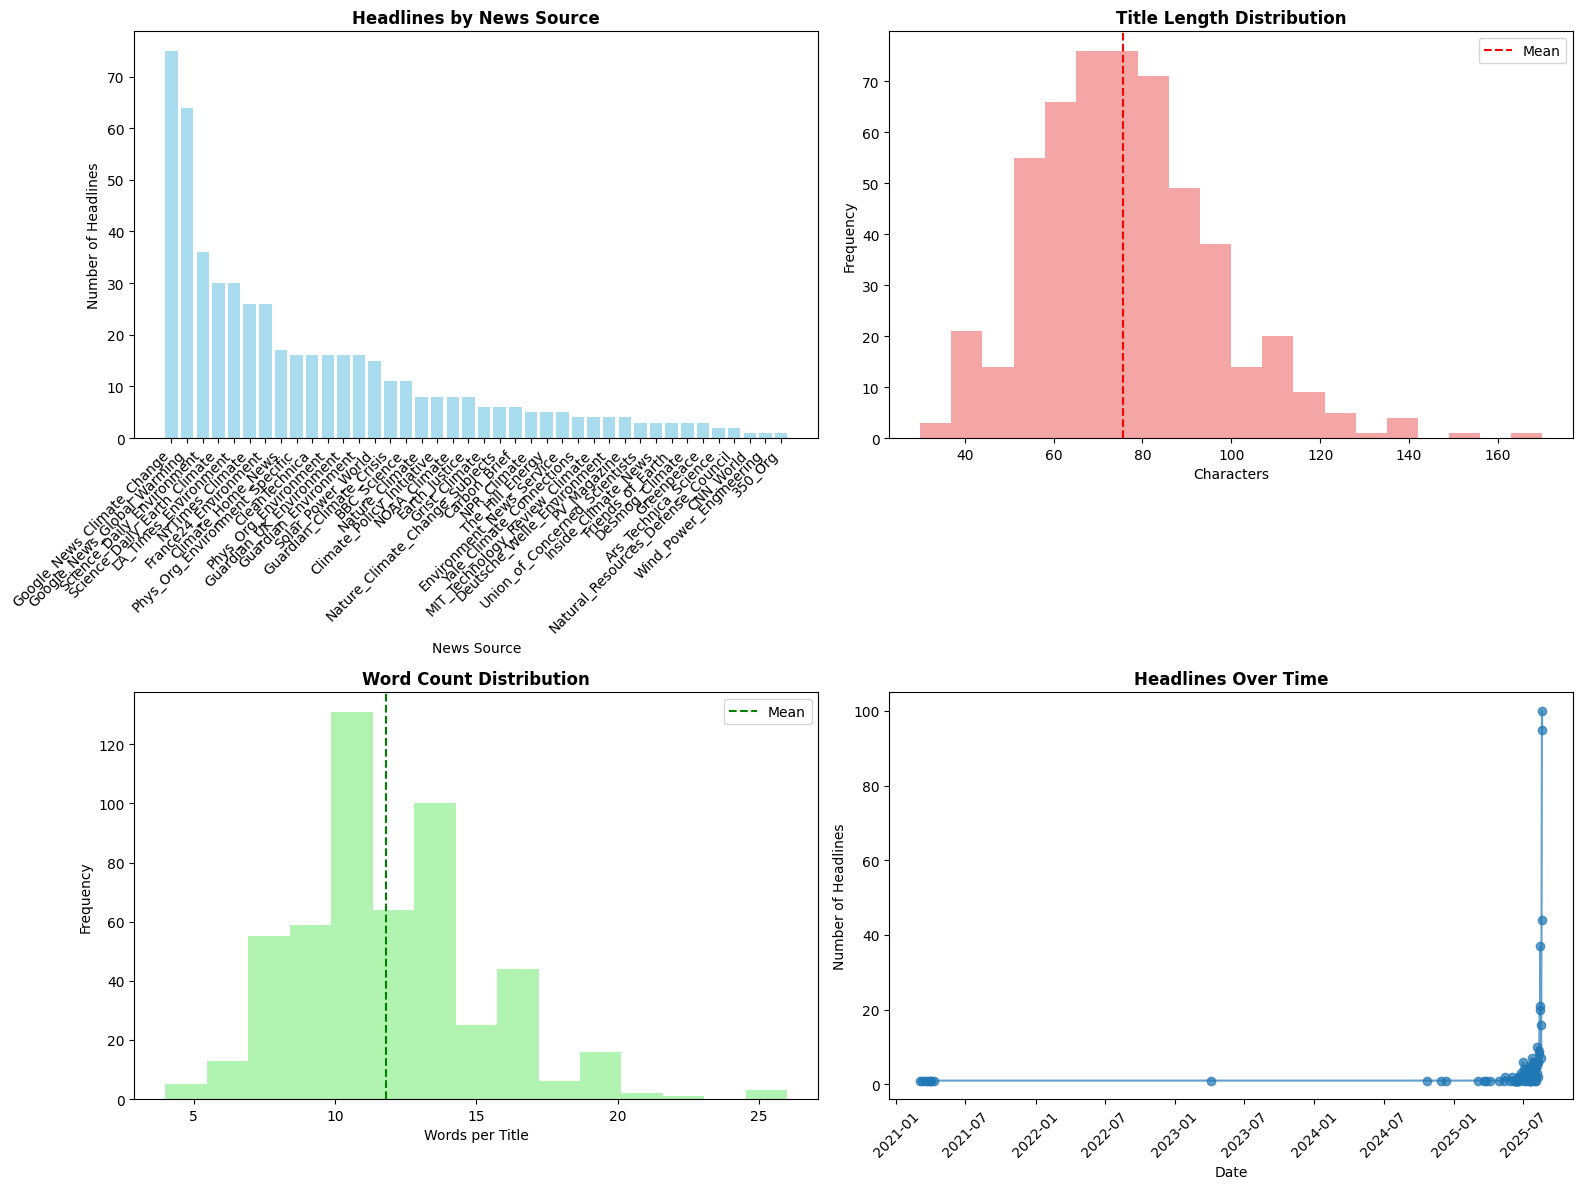

✅ Visualizations created!


In [43]:
if not df_headlines.empty:
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Headlines by source
    source_counts = df_headlines['source'].value_counts()
    ax1.bar(range(len(source_counts)), source_counts.values, color='skyblue', alpha=0.7)
    ax1.set_title('Headlines by News Source', fontweight='bold')
    ax1.set_xlabel('News Source')
    ax1.set_ylabel('Number of Headlines')
    ax1.set_xticks(range(len(source_counts)))
    ax1.set_xticklabels(source_counts.index, rotation=45, ha='right')
    
    # 2. Title length distribution
    ax2.hist(df_headlines['title_chars'], bins=20, alpha=0.7, color='lightcoral')
    ax2.axvline(df_headlines['title_chars'].mean(), color='red', linestyle='--', label='Mean')
    ax2.set_title('Title Length Distribution', fontweight='bold')
    ax2.set_xlabel('Characters')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Word count distribution
    ax3.hist(df_headlines['title_words'], bins=15, alpha=0.7, color='lightgreen')
    ax3.axvline(df_headlines['title_words'].mean(), color='green', linestyle='--', label='Mean')
    ax3.set_title('Word Count Distribution', fontweight='bold')
    ax3.set_xlabel('Words per Title')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    
    # 4. Headlines over time (if date available)
    if df_headlines['published_date'].notna().any():
        df_with_dates = df_headlines.dropna(subset=['published_date'])
        df_with_dates['date_only'] = df_with_dates['published_date'].dt.date
        daily_counts = df_with_dates['date_only'].value_counts().sort_index()
        
        ax4.plot(daily_counts.index, daily_counts.values, marker='o', alpha=0.7)
        ax4.set_title('Headlines Over Time', fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Number of Headlines')
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, 'No date information\navailable', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Timeline Not Available', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizations created!")

## 8. Climate Keyword Analysis

🔍 CLIMATE KEYWORD ANALYSIS
Keywords found: 49
Total keyword occurrences: 692

Top 10 Climate Keywords:
  climate change      : 176 headlines ( 33.6%)
  wildfire            :  58 headlines ( 11.1%)
  pollution           :  54 headlines ( 10.3%)
  global warming      :  40 headlines (  7.6%)
  ecosystem           :  29 headlines (  5.5%)
  fossil fuel         :  23 headlines (  4.4%)
  hurricane           :  22 headlines (  4.2%)
  drought             :  21 headlines (  4.0%)
  greenhouse gas      :  20 headlines (  3.8%)
  solar power         :  19 headlines (  3.6%)


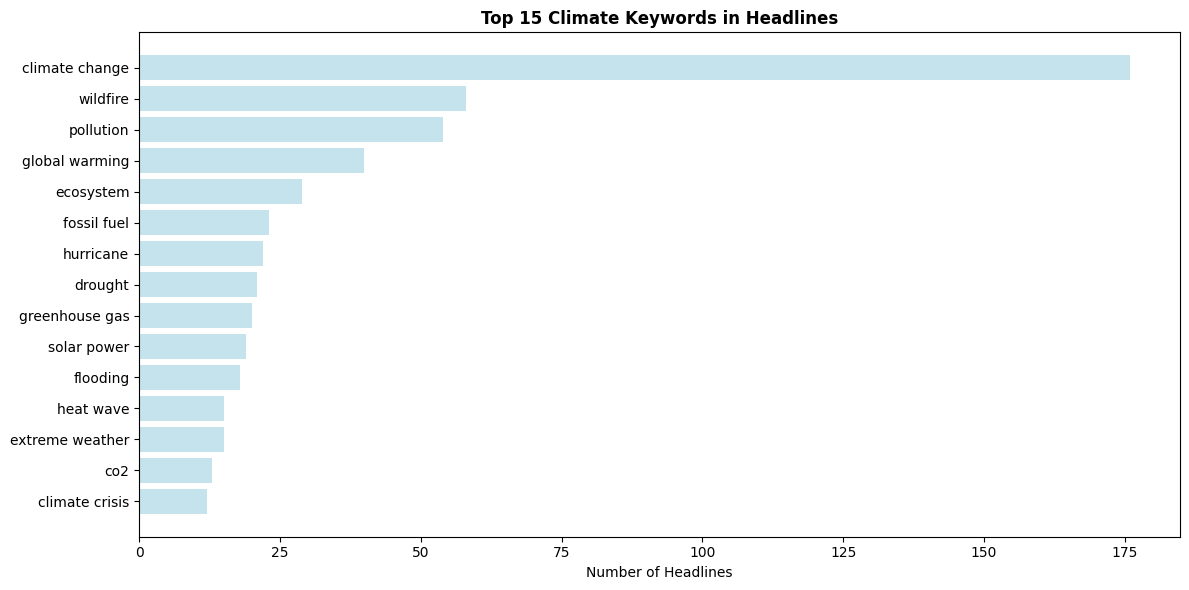

In [44]:
if not df_headlines.empty:
    # Analyze which climate keywords appear most frequently
    keyword_counts = defaultdict(int)
    
    for _, row in df_headlines.iterrows():
        full_text = f"{row['title']} {row['summary']}".lower()
        for keyword in CLIMATE_KEYWORDS:
            if keyword.lower() in full_text:
                keyword_counts[keyword] += 1
    
    # Convert to DataFrame for visualization
    keyword_df = pd.DataFrame([
        {'keyword': k, 'count': v} 
        for k, v in keyword_counts.items() if v > 0
    ]).sort_values('count', ascending=False)
    
    print("🔍 CLIMATE KEYWORD ANALYSIS")
    print("=" * 40)
    print(f"Keywords found: {len(keyword_df)}")
    print(f"Total keyword occurrences: {keyword_df['count'].sum()}")
    
    if len(keyword_df) > 0:
        print("\nTop 10 Climate Keywords:")
        top_keywords = keyword_df.head(10)
        for _, row in top_keywords.iterrows():
            percentage = row['count'] / len(df_headlines) * 100
            print(f"  {row['keyword']:20s}: {row['count']:3d} headlines ({percentage:5.1f}%)")
        
        # Visualize top keywords
        plt.figure(figsize=(12, 6))
        top_15 = keyword_df.head(15)
        plt.barh(range(len(top_15)), top_15['count'].values, color='lightblue', alpha=0.7)
        plt.yticks(range(len(top_15)), top_15['keyword'].values)
        plt.xlabel('Number of Headlines')
        plt.title('Top 15 Climate Keywords in Headlines', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    else:
        print("❌ No climate keywords found in headlines")

## 9. Save Collected Headlines

In [45]:
if not df_headlines.empty:
    # Create data directory if it doesn't exist
    data_dir = "../data/processed"
    os.makedirs(data_dir, exist_ok=True)
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save as CSV
    csv_filename = f"climate_headlines_{timestamp}.csv"
    csv_path = os.path.join(data_dir, csv_filename)
    df_headlines.to_csv(csv_path, index=False)
    
    # Save as JSON for better structure preservation
    json_filename = f"climate_headlines_{timestamp}.json"
    json_path = os.path.join(data_dir, json_filename)
    
    # Convert datetime objects to strings for JSON serialization
    df_json = df_headlines.copy()
    for col in ['published_date', 'collected_date']:
        if col in df_json.columns:
            df_json[col] = df_json[col].astype(str)
    
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(df_json.to_dict('records'), f, indent=2, ensure_ascii=False)
    
    # Save metadata
    metadata = {
        'collection_info': {
            'timestamp': timestamp,
            'total_headlines': len(df_headlines),
            'sources_attempted': len(RSS_FEEDS),
            'sources_successful': df_headlines['source'].nunique(),
            'failed_sources': len(collector.failed_feeds)
        },
        'data_characteristics': {
            'avg_title_length': float(df_headlines['title_chars'].mean()),
            'avg_word_count': float(df_headlines['title_words'].mean()),
            'date_range': {
                'start': str(df_headlines['published_date'].min()),
                'end': str(df_headlines['published_date'].max())
            }
        },
        'keywords_used': CLIMATE_KEYWORDS,
        'sources_configured': list(RSS_FEEDS.keys()),
        'failed_feeds': collector.failed_feeds
    }
    
    metadata_filename = f"climate_headlines_metadata_{timestamp}.json"
    metadata_path = os.path.join(data_dir, metadata_filename)
    
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print("💾 SAVED SUCCESSFULLY!")
    print("=" * 40)
    print(f"📁 CSV file: {csv_path}")
    print(f"📁 JSON file: {json_path}")
    print(f"📁 Metadata: {metadata_path}")
    print(f"📊 Headlines saved: {len(df_headlines)}")
    print(f"💾 File size: {os.path.getsize(csv_path) / 1024:.1f} KB")
    
else:
    print("❌ No headlines to save")

💾 SAVED SUCCESSFULLY!
📁 CSV file: ../data/processed\climate_headlines_20250820_180549.csv
📁 JSON file: ../data/processed\climate_headlines_20250820_180549.json
📁 Metadata: ../data/processed\climate_headlines_metadata_20250820_180549.json
📊 Headlines saved: 524
💾 File size: 341.6 KB


## 10. Compare with Climate Tweets Dataset

📊 CROSS-MEDIA COMPARISON


,Metric,News Headlines,Climate Tweets
0,Total Samples,520,"9,050"
1,Average Character Length,75.4,316.3
2,Average Word Count,11.8,49.7
3,Data Source,RSS feeds from major news outlets,Twitter/X social media
4,Time Period,Recent (RSS feeds),2022 (Jan-Jul)
5,Content Style,"Formal, journalistic","Informal, social"
6,Climate Specificity,High (filtered by keywords),High (climate-focused dataset)


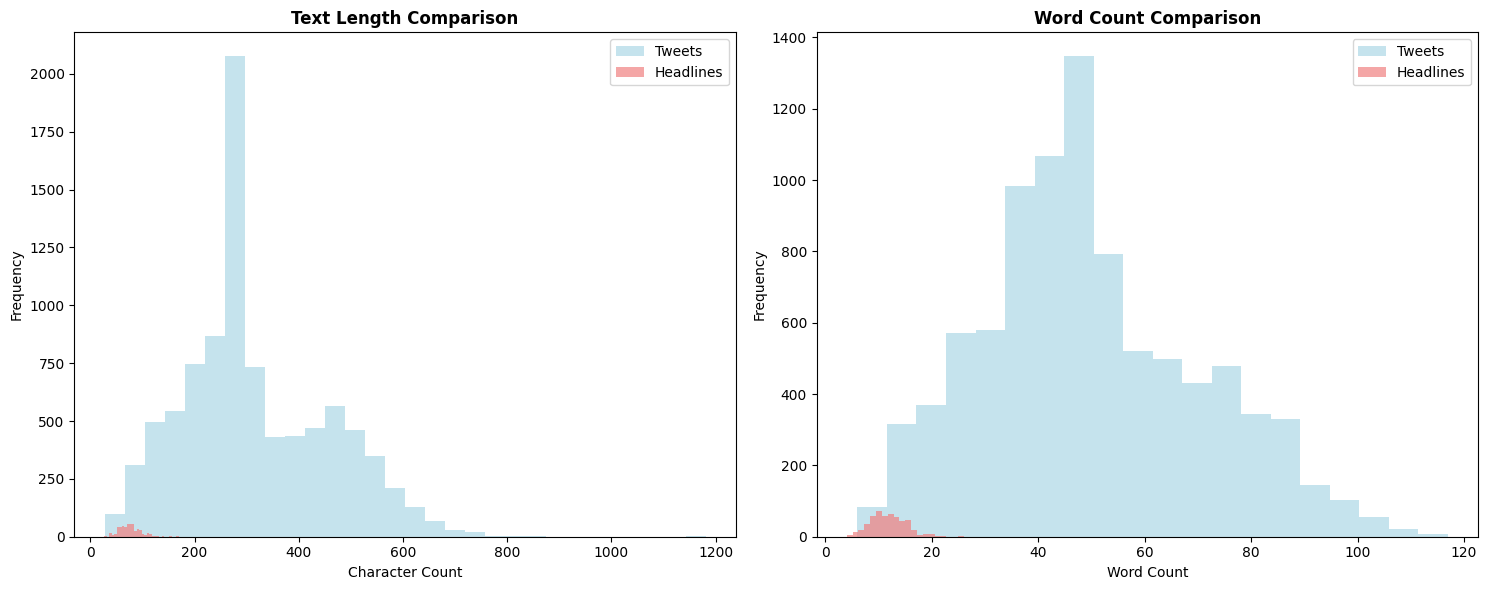


📈 STATISTICAL COMPARISON:
Headlines are 0.2x shorter than tweets
Headlines have 0.2x fewer words than tweets


In [34]:
# Load climate tweets dataset for comparison
tweets_path = "../../Datasets/Climate Change Tweets/Climate change_2022-1-17_2022-7-19.csv"

try:
    df_tweets = pd.read_csv(tweets_path)
    
    # Basic preprocessing of tweets
    df_tweets['clean_text'] = df_tweets['Embedded_text'].fillna(df_tweets['Text'])
    df_tweets['text_length'] = df_tweets['clean_text'].str.len()
    df_tweets['word_count'] = df_tweets['clean_text'].str.split().str.len()
    
    print("📊 CROSS-MEDIA COMPARISON")
    print("=" * 50)
    
    comparison_data = {
        'Metric': [
            'Total Samples',
            'Average Character Length',
            'Average Word Count',
            'Data Source',
            'Time Period',
            'Content Style',
            'Climate Specificity'
        ],
        'News Headlines': [
            f"{len(df_headlines):,}" if not df_headlines.empty else "0",
            f"{df_headlines['title_chars'].mean():.1f}" if not df_headlines.empty else "N/A",
            f"{df_headlines['title_words'].mean():.1f}" if not df_headlines.empty else "N/A",
            "RSS feeds from major news outlets",
            "Recent (RSS feeds)",
            "Formal, journalistic",
            "High (filtered by keywords)"
        ],
        'Climate Tweets': [
            f"{len(df_tweets):,}",
            f"{df_tweets['text_length'].mean():.1f}",
            f"{df_tweets['word_count'].mean():.1f}",
            "Twitter/X social media",
            "2022 (Jan-Jul)",
            "Informal, social",
            "High (climate-focused dataset)"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    if not df_headlines.empty:
        # Text length comparison visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Character length comparison
        ax1.hist(df_tweets['text_length'].dropna(), bins=30, alpha=0.7, label='Tweets', color='lightblue')
        ax1.hist(df_headlines['title_chars'], bins=30, alpha=0.7, label='Headlines', color='lightcoral')
        ax1.set_title('Text Length Comparison', fontweight='bold')
        ax1.set_xlabel('Character Count')
        ax1.set_ylabel('Frequency')
        ax1.legend()
        
        # Word count comparison
        ax2.hist(df_tweets['word_count'].dropna(), bins=20, alpha=0.7, label='Tweets', color='lightblue')
        ax2.hist(df_headlines['title_words'], bins=20, alpha=0.7, label='Headlines', color='lightcoral')
        ax2.set_title('Word Count Comparison', fontweight='bold')
        ax2.set_xlabel('Word Count')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n📈 STATISTICAL COMPARISON:")
        print(f"Headlines are {df_headlines['title_chars'].mean() / df_tweets['text_length'].mean():.1f}x shorter than tweets")
        print(f"Headlines have {df_headlines['title_words'].mean() / df_tweets['word_count'].mean():.1f}x fewer words than tweets")
    
except FileNotFoundError:
    print(f"❌ Climate tweets dataset not found at: {tweets_path}")
    print("Headlines collected independently.")
except Exception as e:
    print(f"❌ Error loading tweets dataset: {e}")

## 11. Summary and Next Steps

In [35]:
print("🎉 CLIMATE HEADLINES COLLECTION COMPLETE!")
print("=" * 60)

if not df_headlines.empty:
    print(f"✅ Successfully collected {len(df_headlines)} climate-related headlines")
    print(f"✅ Data saved to CSV and JSON formats")
    print(f"✅ Metadata and analysis results preserved")
    
    print("\n📊 COLLECTION STATISTICS:")
    print(f"  • News sources processed: {df_headlines['source'].nunique()}")
    print(f"  • Average headline length: {df_headlines['title_chars'].mean():.1f} characters")
    print(f"  • Average word count: {df_headlines['title_words'].mean():.1f} words")
    print(f"  • Climate keywords detected: {len(set(CLIMATE_KEYWORDS))} types")
    
else:
    print("⚠️  No headlines were collected in this run")
    print("   This could be due to:")
    print("   • Network connectivity issues")
    print("   • RSS feed access restrictions")
    print("   • Overly restrictive keyword filtering")
    print("   • Temporary server issues")

print("\n🚀 NEXT STEPS FOR EMOTION ANALYSIS:")
print("=" * 40)
print("1. 🔄 Load GoEmotions dataset for model training")
print("2. 🤖 Fine-tune RoBERTa on emotion classification")
print("3. 🎯 Apply trained model to climate headlines")
print("4. 📊 Compare emotion patterns: Headlines vs Tweets")
print("5. 📈 Statistical analysis of emotion differences")
print("6. 🔍 Interpretability analysis with SHAP")
print("7. 📝 Generate final research report")

print("\n💡 RESEARCH INSIGHTS READY:")
print("=" * 40)
print("• Cross-media emotion analysis (Headlines vs Tweets)")
print("• Climate discourse emotion patterns")
print("• News vs social media emotion differences")
print("• Temporal emotion trends in climate communication")

print("\n✨ Dataset is ready for the next phase of emotion analysis!")

🎉 CLIMATE HEADLINES COLLECTION COMPLETE!
✅ Successfully collected 520 climate-related headlines
✅ Data saved to CSV and JSON formats
✅ Metadata and analysis results preserved

📊 COLLECTION STATISTICS:
  • News sources processed: 40
  • Average headline length: 75.4 characters
  • Average word count: 11.8 words
  • Climate keywords detected: 64 types

🚀 NEXT STEPS FOR EMOTION ANALYSIS:
1. 🔄 Load GoEmotions dataset for model training
2. 🤖 Fine-tune RoBERTa on emotion classification
3. 🎯 Apply trained model to climate headlines
4. 📊 Compare emotion patterns: Headlines vs Tweets
5. 📈 Statistical analysis of emotion differences
6. 🔍 Interpretability analysis with SHAP
7. 📝 Generate final research report

💡 RESEARCH INSIGHTS READY:
• Cross-media emotion analysis (Headlines vs Tweets)
• Climate discourse emotion patterns
• News vs social media emotion differences
• Temporal emotion trends in climate communication

✨ Dataset is ready for the next phase of emotion analysis!
